## Import dependencies

In [ ]:
pip install tensorflow

In [2]:
import mediapipe as mp
import numpy as np
import cv2 as cv2
import os
from matplotlib import pyplot as plt
import time

## Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color = (51,255,255), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color = (153,0,76), thickness=1, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (51,102,0), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (102,78,255), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))

In [7]:
cap = cv2.VideoCapture(0);
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5 ) as holistic:
    while cap.isOpened():
        ret,frame = cap.read()
        image, results = mediapipe_detection(frame,holistic)
#         print(results)
        draw_styled_landmarks(image,results)
        cv2.imshow('OpenCv Window',image)
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [8]:
draw_styled_landmarks(frame,results) 

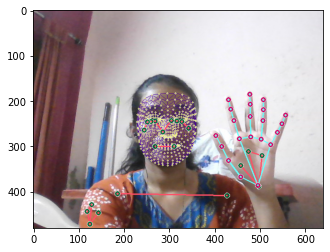

In [9]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [10]:
# img = cv2.imread("img.jpg")

In [11]:
# with mp_holistic.Holistic(static_image_mode=True) as holistic :
#     result = holistic.process(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#     print('NOSE world landmarks : ')
#     print(result.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.NOSE])
    
# #     Plot pose world landmarks
#     mp_drawing.plot_landmarks(
#     result.pose_world_landmarks,mp_holistic.POSE_CONNECTIONS)

## Extract key value points

In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404) 
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63) 
    return np.concatenate([pose,face,lh,rh])

In [13]:
result_test = extract_keypoints(results)

In [14]:
result_test.shape

(1662,)

In [15]:
np.save('0', result_test)

## Setup Folders for Collection

In [16]:
DATA_PATH = os.path.join('MP_DATA')
actions = np.array(['hello','thanks','iloveyou'])
no_seq = 30
seq_len = 30
st_folder = 30

In [17]:
for action in actions :
    for sequence in range(no_seq) :
        try :
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except :
            pass

## Collect Keypoints values for training and testing

In [18]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5 ) as holistic:
    
    # NEW LOOP through actions
    for action in actions :
        for sequence in range(no_seq) :
            for frame_num in range(seq_len) :
                ret,frame = cap.read()
                image, results = mediapipe_detection(frame,holistic)
                # print(results)
                draw_styled_landmarks(image,results)
                
                # New "Apply wait" logic
                if frame_num == 0 :
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),1,cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCv Window',image)
                    cv2.waitKey(2000)
                else :
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                     # Show to screen
                    cv2.imshow('OpenCv Window',image)
                    
                # NEW EXPORT keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence),str(frame_num))
                np.save(npy_path, keypoints)
                
                if cv2.waitKey(10) & 0xff == ord('q'):
                    break
        
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [40]:
np.load(r'C:\Users\Nida Shaikh\JuPyNB\SemV_MP\MP_DATA\hello\15\15.npy')

array([ 0.48525986,  0.42483172, -0.55105078, ...,  0.        ,
        0.        ,  0.        ])

In [38]:
keypoints.shape

(1662,)

## Preprocess data and create labels

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [21]:
label_map = {label:num for num,label in enumerate(actions)}

In [22]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [23]:
sequences, labels = [], []
for action in actions :
    for sequence in range(no_seq):
        window = []
        for frame_num in range(seq_len):
            res = np.load(os.path.join(DATA_PATH,action, str(sequence),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [36]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_seq):
        window = []
        for frame_num in range(seq_len):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [37]:
np.array(sequences).shape

C:\Users\NIDASH~1\AppData\Local\Temp/ipykernel_18200/1188987122.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(sequences).shape


(90, 30)

In [32]:
np.array(labels).shape

(90,)

In [30]:
sequences.shape

AttributeError: 'list' object has no attribute 'shape'